In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re
from env import user, password, host
import acquire
import prepare

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

1) Spam Data

    a) Load the spam data set.

In [40]:
url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


b) Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [145]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


def clean(text):
    '''Simplified text cleaning function'''
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^w\s]", '', text).lower()

In [117]:
# create df of spam only
spam = df[df.label == 'spam']
spam

,label,text
id,,
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...


In [115]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['count', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

,count,percent
ham,4825,0.865937
spam,747,0.134063


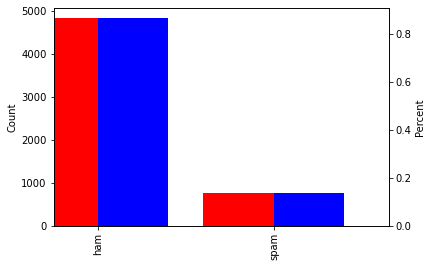

In [45]:
x = show_counts_and_ratios(df, "label")

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4
x["count"].plot(kind='bar', color='red', ax=ax, width=width, position=1)
x["percent"].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Count')
ax2.set_ylabel('Percent')

plt.show()

In [153]:
# clean and separate ham/spam words
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [79]:
# frequency
ham_freq = pd.Series(ham_words.split()).value_counts()
spam_freq = pd.Series(spam_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [85]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [86]:
counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)
counts.columns = ['ham', 'spam', 'all']
counts.head()

,ham,spam,all
i,2305,45,2350
you,1837,287,2124
to,1554,686,2240
the,1118,204,1322
a,1055,376,1431


In [68]:
counts.ham.sort_values(ascending=False).head()

i      2305
you    1837
to     1554
the    1118
a      1055
Name: ham, dtype: int64

In [69]:
counts.spam.sort_values(ascending=False).head()

to      686
a       376
call    347
you     287
your    263
Name: spam, dtype: int64

In [70]:
# highest frequency 'spam' words that don't appear in 'ham'
counts[counts.ham==0].sort_values('spam', ascending=False).head(10)

,ham,spam
claim,0,113
prize,0,92
won,0,73
guaranteed,0,50
tone,0,48
18,0,43
awarded,0,38
a1000,0,35
150ppm,0,34
a2000,0,31


In [71]:
# highest frequency 'ham' words that don't appear in 'spam'
counts[counts.spam==0].sort_values('ham', ascending=False).head(10)

,ham,spam
ltgt,276,0
he,184,0
lor,160,0
later,134,0
da,131,0
she,130,0
thats,94,0
say,91,0
ask,88,0
said,86,0


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

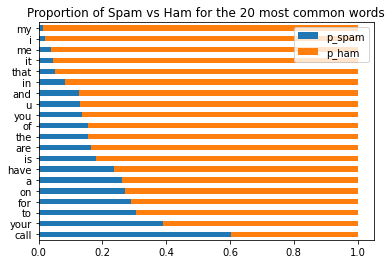

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [92]:
word_counts['all'].sort_values(ascending=False).head(20)

i       2350
to      2240
you     2124
a       1431
the     1322
u       1133
and      970
is       886
in       884
me       786
my       753
for      704
your     677
of       619
it       618
call     576
have     573
on       535
that     512
are      489
Name: all, dtype: int64

In [22]:
from wordcloud import WordCloud

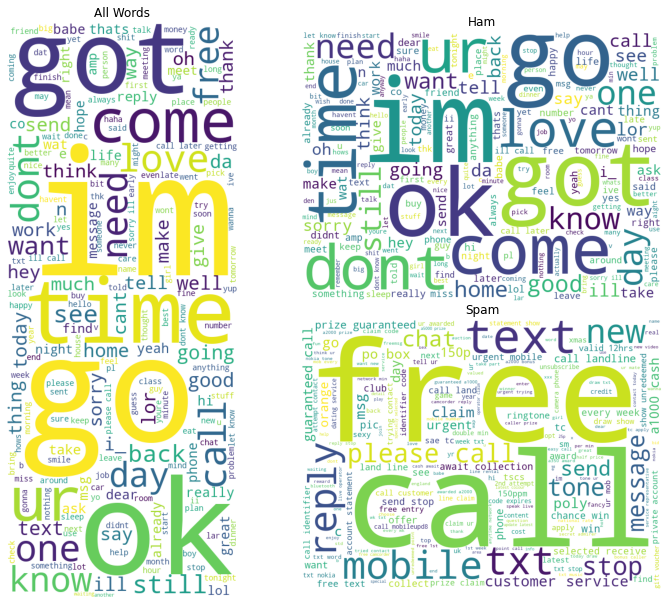

In [149]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')


In [160]:
bigrams = nltk.ngrams(ham_words, 2)
list(bigrams)[:10]

[('go', 'jurong'),
 ('jurong', 'point'),
 ('point', 'crazy'),
 ('crazy', 'available'),
 ('available', 'bugis'),
 ('bugis', 'n'),
 ('n', 'great'),
 ('great', 'world'),
 ('world', 'la'),
 ('la', 'e')]

In [167]:
top_15_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(15))

top_15_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

TypeError: reset_index() got an unexpected keyword argument 'ascending'

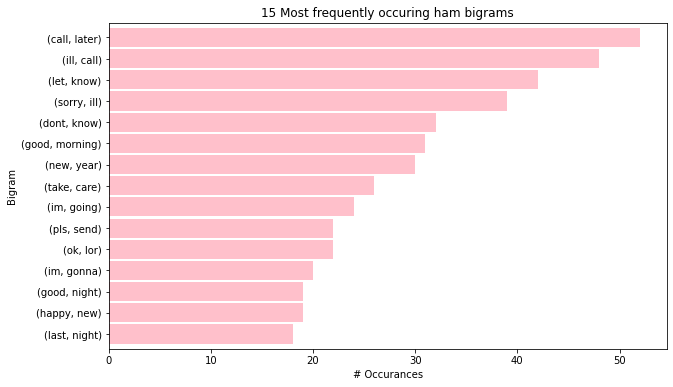

In [187]:
top_15_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('15 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_15_ham_bigrams.reset_index(ascending=False)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [162]:
bigrams = nltk.ngrams(spam_words, 2)
list(bigrams)[:10]

[('free', 'entry'),
 ('entry', 'wkly'),
 ('wkly', 'comp'),
 ('comp', 'win'),
 ('win', 'fa'),
 ('fa', 'cup'),
 ('cup', 'final'),
 ('final', 'tkts'),
 ('tkts', '21st'),
 ('21st', 'may')]

In [189]:
top_15_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(15))

top_15_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(guaranteed, call)     23
(a1000, cash)          23
dtype: int64

TypeError: reset_index() got an unexpected keyword argument 'ascending'

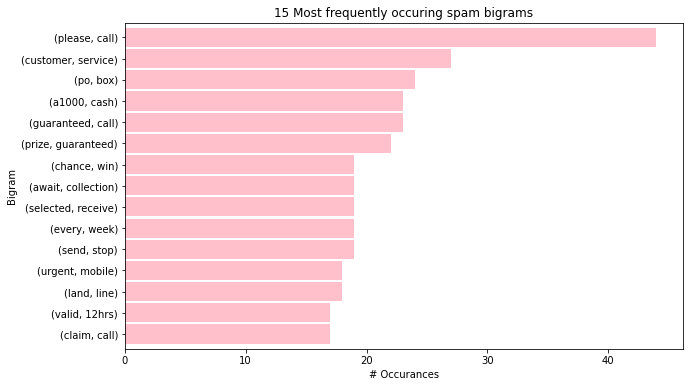

In [190]:
top_15_spam_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('15 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_15_spam_bigrams.reset_index(ascending=False)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [172]:
from wordcloud import WordCloud

In [173]:
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

In [180]:
top_15_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(15))

top_15_ham_trigrams.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(right, pls, send)      12
dtype: int64

TypeError: reset_index() got an unexpected keyword argument 'ascending'

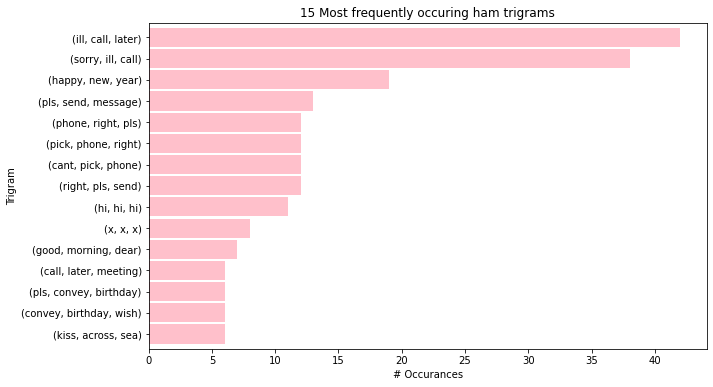

In [191]:
top_15_ham_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('15 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_15_ham_trigrams.reset_index(ascending=False)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

c) Is there any overlap in the bigrams for the spam data and the ham data?

In [26]:
# there doesn't appear to be much overlap.  The direction of the conversation appears to be oppositie with the ham data referencing I and the spam you more frequently.  

d) Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [193]:
top_10_ham_trigrams = nltk.ngrams(ham_words, 3)
list(top_10_ham_trigrams)[:10]

[('go', 'jurong', 'point'),
 ('jurong', 'point', 'crazy'),
 ('point', 'crazy', 'available'),
 ('crazy', 'available', 'bugis'),
 ('available', 'bugis', 'n'),
 ('bugis', 'n', 'great'),
 ('n', 'great', 'world'),
 ('great', 'world', 'la'),
 ('world', 'la', 'e'),
 ('la', 'e', 'buffet')]

In [199]:
top_15_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(15))

top_15_ham_trigrams.head(15)

(ill, call, later)          42
(sorry, ill, call)          38
(happy, new, year)          19
(pls, send, message)        13
(right, pls, send)          12
(cant, pick, phone)         12
(pick, phone, right)        12
(phone, right, pls)         12
(hi, hi, hi)                11
(x, x, x)                    8
(good, morning, dear)        7
(kiss, across, sea)          6
(convey, birthday, wish)     6
(pls, convey, birthday)      6
(call, later, meeting)       6
dtype: int64

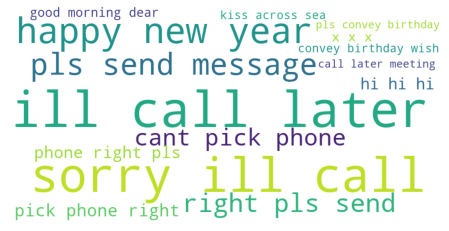

In [200]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_15_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [202]:
top_15_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(15))

top_15_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(reply, call, 08000930705)    14
(land, line, claim)           14
(2003, account, statement)    13
dtype: int64

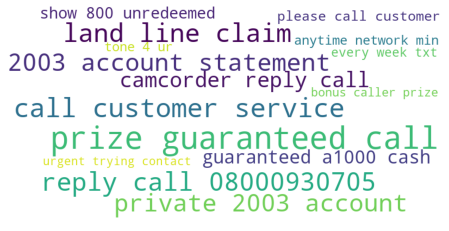

In [203]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_15_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

2) Explore the blog articles using the techniques discussed in the exploration lesson.

In [204]:
df = acquire.get_blog_articles()

/Users/albertopuentes/Desktop/codeup-data-science/natural-language-processing-exercises/acquire.py:16: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 16 of the file /Users/albertopuentes/Desktop/codeup-data-science/natural-language-processing-exercises/acquire.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)


In [205]:
df.head()

,title,published_date,blog_image,content
0,Codeup’s Data Science Career Accelerator is Here!,"September 30, 2018",https://codeup.com/wp-content/uploads/2018/10/...,The rumors are true! The time has arrived. Cod...
1,Data Science Myths,"October 31, 2018",https://codeup.com/wp-content/uploads/2018/10/...,By Dimitri Antoniou and Maggie Giust\nData Sci...
2,Data Science VS Data Analytics: What’s The Dif...,"October 17, 2018",https://codeup.com/wp-content/uploads/2018/10/...,"By Dimitri Antoniou\nA week ago, Codeup launch..."
3,10 Tips to Crush It at the SA Tech Job Fair,"August 14, 2018",None,SA Tech Job Fair\nThe third bi-annual San Anto...
4,Competitor Bootcamps Are Closing. Is the Model...,"August 14, 2018",None,Competitor Bootcamps Are Closing. Is the Model...


In [37]:
df['clean'] = df['title'].apply(lambda x: prepare.remove_stopwords(prepare.tokenize(prepare.basic_clean(x))))

In [ ]:
def ngrams_wordcloud (text_list, title_list, n=2):
    for i in  range (0, len(text_list)):
        plt.figure(figsize=(20,16))
        plt.subplot(2,2,1)
        pd.Series(nltk.ngrams(text_list[i].split(), n=n)).value_counts().head(10).plot.barh()
        plt.title(f'Top 10 most common {title_list[i]} ngrams where n={n}')
        plt.subplot(2,2,2)
        img = WordCloud(background_color='white', width=800, height=600).generate(text_list[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Top 10 most common {title_list[i]} ngrams where n={n}')
        #plt.tight_layout()
        plt.show()